## Imports

In [57]:
import pandas as pd
from PIL import Image
from fr_utils import *
from inception_blocks import *
from matplotlib.pyplot import figure

%matplotlib qt

from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm

# imports for LIME
import sklearn
import sklearn.datasets
import sklearn.ensemble

import lime
import lime.lime_tabular
from lime import lime_image
from __future__ import print_function

## Setup Model and load Database

In [58]:
def triplet_loss(y_true, y_pred, alpha = 0.2):

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    
    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    
    # subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    
    # maximum of basic_loss and 0.0
    loss = tf.reduce_sum(tf.maximum(basic_loss,0))

    return loss

In [61]:

# given image, returns encoding
def img_to_encoding(img1, model):
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding


# given image path, returns encoding
def img_path_to_encoding(image_path, model):
    return img_to_encoding(cv2.imread(image_path, 1), model)

In [59]:
# specify model input, compile, then load the weights
FRmodel= faceRecoModel(input_shape=(3, 96, 96))
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [62]:
# Fill database here with image encodings
database = {}
database['Greg'] = img_path_to_encoding("images/greg_positive.jpg", FRmodel)
database['Maxim'] = img_path_to_encoding("images/maxim_positive.jpg", FRmodel)

## Create LIME explainer

In [63]:
# init LIME explainer and segmentation function
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=50, compactness=1, sigma=1)

In [64]:
# given list of images, gets probability of each image being 'Greg'
def get_probability(imgs):
    dists = []
    for i in range(len(imgs)):
        # runs image through FaceNet model
        encoding = img_to_encoding(imgs[i], FRmodel)
        
        # calculates distance from 'Greg'
        dist = np.linalg.norm(encoding-database["Greg"])
        
        # [prob of being Greg, prob of being not Greg]
        dists.append([1-dist, dist])
    return dists

In [72]:
# outputs superpixel features that most significantly contribute to results
def get_explanation(img_path):
    # get image
    inputIMG = cv2.imread(img_path, 1)
    
    res = get_probability([inputIMG])[0]
    if res[0] > .3:
        print("It is Greg!")
    else:
        print("Not a Greg.")

    # get explanation from LIME
    explanation = explainer.explain_instance(inputIMG, 
                                            classifier_fn = get_probability, top_labels=2, 
                                            hide_color=0, num_samples=100, segmentation_fn=segmenter)

    # display top 5 features
    for i in range(5, 0, -1):
        temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=i, hide_rest=False)
        plt.figure()
        plt.imshow(mark_boundaries(temp, mask))

## Show explanation

In [71]:
get_explanation("images/greg_positive.jpg")

It is Greg!


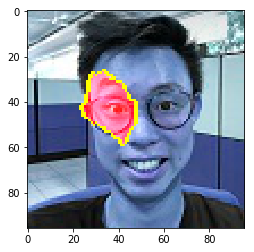

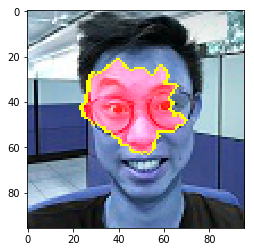

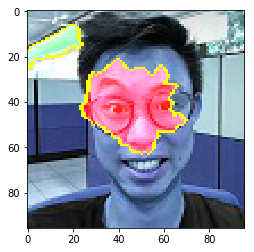

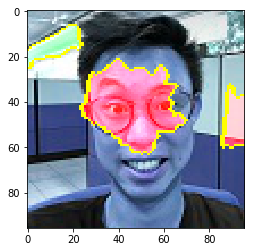

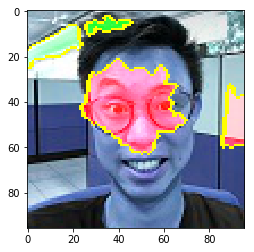

<Figure size 432x288 with 0 Axes>

In [295]:
get_explanation("images/maxim_positive.jpg")